# Association Rules
## Example with the [__Online Retail__](https://archive.ics.uci.edu/ml/datasets/online+retail) dataset, from UCI
The dataset is an excel file containing __commercial transactions__.
The columns are the following `InvoiceNo`	`StockCode`	`Description`	`Quantity`	`InvoiceDate`	`UnitPrice`	`CustomerID`
The commercial transaction is identified by the `InvoiceNo`, all the items in the transaction have the same `InvoiceNo`. The items are described by `StockCode` and `Description`, we will consider only the description, for ease of comprehension. `Quantity` will be used only in the preparation operations, while the remaining features will be disregarded.

Code inspired by the solution in this [link](http://pbpython.com/market-basket-analysis.html)

## Workflow
1. read the excel file and do some exploration
    - we are interested in particular in the unique values, that will give an idea of the number of transactions and different items
2. data cleaning: as __background information__ we are told that there are some issues in the data
    - a few number of descriptions has spurious leading or trailing spaces, we must remove them, to avoid that the strings like "`Alarm Clock`" and "` Alarm clock`" are considered different; the function `.str.strip()` does the trick
    - rows with null `InvoiceNo` must be removed
    - rows with `InvoiceNo` containing a "C" must be removed
    - rows with description "POSTAGE" must be removed
3. the cleaned dataset must be restructured, in order to have one row per transaction and one column for each distinct item; a transaction row has `True` in correspondance to the columns of the items it contains, `False` otherwise; the boolean values will be represented with `1` and `0`. Actions:
    1. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`
    2. use the `unstack` function to move the items from rows to columns
    3. fill the missing with zero (`fillna(0)`)
    4. change positives to `1` and non-positives to `0` and store the result in the new dataframe `basket` and inspect it
4. setting the hyperparameters for rule generation: we need to find a reasonable number of rules, not too few and not too many; the first requirement for a rule is a good interestingness measure; a possible strategy is 
    - to decide the interestingness measure, its threshold and the number of rules we are interested in
        - we will use `lift` for the metric, with `min_threshold=1` and `20` rules
    - find the appropriate support threshold with a balance between too few itemsets (__minimum support__ very high) and too many itemsets (__minimum support__ very small); this will be obtained with a loop of trials
5. loop of trials 
    - for `min_support` starting from 1 going down with step -0.01
        - find the frequent itemsets with the current `min_support`
        - find the association rules with the given metric and threshold
        - if the number of association rules is not less than the required number
            - end the loop
        - else 
            - decrease `min_support` subtracting the step
6. show the `min_support` used and the rules sorted by decreasing metric


In [1]:
try:
    from mlxtend.frequent_patterns import apriori, association_rules
except ImportError:
    # !conda install -c conda-forge -n base mlxtend --yes # install mlxtend if not already installed
    !pip install mlxtend
    from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
import sys
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import seaborn as sns

print(f"Python Version: {sys.version}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Seaborn Version: {sns.__version__}")


Python Version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 21:00:12) [Clang 16.0.6 ]
NumPy Version: 1.26.4
Pandas Version: 2.2.3
scikit-learn Version: 1.6.1
Matplotlib Version: 3.10.0
Seaborn Version: 0.13.2


Upload the file `'Online-Retail-France.xlsx'`. It is a MS Excel file, you can read it with the Pandas' function `read_excel`.

Inspect its content. It is a transactional database where the role of transaction identifier is played by the column `InvoiceNo` and the items are in the column `Description`.

In [3]:
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
url = 'Online-Retail-France.xlsx'
df0 = pd.read_excel(url
                    # , dtype = {  'InvoiceNo': 'str'
                    #               , 'StockCode':'str'
                    #               , 'Description':'str'
                    #               , 'CustomerID':'Int64'
                    #               }
                    )
print("There are {} rows and {} columns".format(df0.shape[0], df0.shape[1]))

There are 8557 rows and 7 columns


In [4]:
df0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0


In [5]:
df0.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8557 entries, 0 to 8556
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    8556 non-null   object 
 1   StockCode    8557 non-null   object 
 2   Description  8557 non-null   object 
 3   Quantity     8557 non-null   int64  
 4   InvoiceDate  8557 non-null   object 
 5   UnitPrice    8557 non-null   float64
 6   CustomerID   8491 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 468.1+ KB


In [6]:
print("The number of unique Description values in the input file is {}".format(len(df0['Description'].unique())))

The number of unique Description values in the input file is 1565


In [7]:
df1 = df0
df1['Description'] = df0['Description'].str.strip()

In [8]:
print("After cleaning, the number of unique Description values in the input file is {}".format(len(df1['Description'].unique())))

After cleaning, the number of unique Description values in the input file is 1564


Some rows may not have an `InvoiceNo` and must be removed, because they cannot be used.

Check if there are such that rows and in case remove them. 

In [9]:
print("Rows with missing InvoiceNo before removing")
df1[df1['InvoiceNo'].isna()]

Rows with missing InvoiceNo before removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
15,NaN,21913,VINTAGE SEASIDE JIGSAW PUZZLES,12,2010-12-01 08:45:00,3.75,12583.0


In [10]:
df2 = df1.dropna(axis=0, subset=['InvoiceNo'])

In [11]:
print("Rows with missing InvoiceNo after removing")
df2[df2['InvoiceNo'].isna()]

Rows with missing InvoiceNo after removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID


Some InvoiceNo start with a `C`. They are "credit transactions" and must be removed.

Check the number of rows containing `C` in `InvoiceNo` and remove them. 
At the moment the column `InvoiceNo` is a generic object, in order to be 
able to use string functions, such as `contains`, it must be transformed into `str` with `astype`.

In [12]:
container = 'InvoiceNo'
target = 'C'
print("There are {} rows containing {} in {}"\
      .format(sum(df2[container].str.contains(target)), target, container))

There are 149 rows containing C in InvoiceNo


In [13]:
df3 = df2[~df2[container].str.contains(target)]

In [14]:
print("After removal, there are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df3['InvoiceNo'].str.contains('C'))))

After removal, there are 0 rows containing 'C' in 'InvoiceNo'


Several transactions include the item `'POSTAGE'`, 
which represents the mailing expenses. 
In this analysis we are not interested in it, therefore the rows 
with `'POSTAGE'` will be removed.

In [15]:
container = 'Description'
target = 'POSTAGE'
print("There are {} rows containing {} in {}"\
      .format(sum(df3[container].str.contains(target)), target, container))

There are 300 rows containing POSTAGE in Description


In [16]:
df = df3[~df3[container].str.contains(target)]
print("After cleaning there are {} rows containing {} in {}"\
      .format(sum(df[container].str.contains(target)), target, container))

After cleaning there are 0 rows containing POSTAGE in Description


In [17]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
count,8107,8107,8107,8107.000000,8107,8107.00000,8041.000000
unique,387,1541,1562,NaN,388,NaN,NaN
top,570672,23084,RABBIT NIGHT LIGHT,NaN,2011-10-11 14:52:00,NaN,NaN
freq,259,74,74,NaN,259,NaN,NaN
mean,NaN,NaN,NaN,13.724806,NaN,3.83965,12679.910583
std,NaN,NaN,NaN,21.354558,NaN,66.58728,281.252392
min,NaN,NaN,NaN,1.000000,NaN,0.00000,12413.000000
25%,NaN,NaN,NaN,6.000000,NaN,1.00000,12571.000000
50%,NaN,NaN,NaN,10.000000,NaN,1.65000,12674.000000
75%,NaN,NaN,NaN,12.000000,NaN,2.95000,12689.000000


After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. 

Actions in step 3:
1. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`
1. use the `unstack` function to move the items from rows to columns
1. fill the missing with zero (`fillna(0)`)
1. substitute positive values with `1` and non positive with `0`, store the result in the new dataframe `basket_sets` and inspect it

3.1. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`

In [18]:
basket0 = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
basket0.sample(10)

InvoiceNo  Description                       
575193     BOTANICAL LILY GREETING CARD          12
542629     POPPY'S PLAYHOUSE LIVINGROOM          12
564670     CHILDREN'S CIRCUS PARADE MUG          12
553195     PACK OF 6 SKULL PAPER PLATES          12
570823     CHILDRENS CUTLERY DOLLY GIRL          24
546678     SET/20 RED RETROSPOT PAPER NAPKINS    12
565854     LUNCH BAG WOODLAND                    20
552826     SINGLE ANTIQUE ROSE HOOK IVORY        12
576087     CHILDRENS APRON SPACEBOY DESIGN        8
539050     FELTCRAFT CHRISTMAS FAIRY              1
Name: Quantity, dtype: int64

3.2. use the `unstack` function to move the items from rows to columns

In [19]:
basket1 = basket0.unstack()
basket1.sample(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
580736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553208,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
566115,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3.3. fill the missing with zero (`fillna(0)`)

In [20]:
basket2 = basket1.fillna(0)
basket2.sample(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
553357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
570879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
566873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
578541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
577856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this moment, each number represent the number of pieces sold in a transaction for each item in the description.

Here we see a lot of zeros, but, just to explore, we can look at the description of the dataframe at this stage.

In [21]:
basket2.describe()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,...,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,0.868217,0.310078,0.005168,0.062016,0.509044,0.385013,0.400517,0.062016,0.281654,0.186047,...,0.193798,0.023256,0.010336,0.002584,0.082687,0.279070,0.012920,0.186047,0.031008,0.062016
std,5.109242,2.474110,0.101666,0.861544,5.445138,2.978173,3.454711,1.219989,2.006660,1.484466,...,2.195417,0.340644,0.203331,0.050833,1.626651,2.348994,0.254164,1.922464,0.609994,0.861544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.000000,20.000000,2.000000,12.000000,96.000000,24.000000,48.000000,24.000000,24.000000,12.000000,...,25.000000,6.000000,4.000000,1.000000,32.000000,36.000000,5.000000,24.000000,12.000000,12.000000


We observe that the counts of different values in the columns ranges through several units.

Since we are only interested in the presence or absence of an item in a transaction:

3.4. substitute positive values with `1` and non positive with `0`
- use `.clip(0)` to convert negatives to 0
- use `.astype()` to convert into boolean; Python interprets `0` as `False` and _non-zero integers_ as `True`


In [22]:
basket_sets = basket2.clip(0).astype('bool')
basket_sets.describe()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
count,387,387,387,387,387,387,387,387,387,387,...,387,387,387,387,387,387,387,387,387,387
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,375,381,386,385,381,380,380,386,378,381,...,384,385,386,386,386,380,386,383,386,385


## 4. setting the hyperparameters for rule generation
We need to find a reasonable number of rules, not too few and not too many; the first requirement for a rule is a good interestingness measure; a possible strategy is 
- to decide the interestingness measure, its threshold and the number of rules we are interested in
    - we will use `lift` for the metric, with `min_threshold=1` and `20` rules
- find the appropriate support threshold with a balance between too few itemsets (__minimum support__ very high) and too many itemsets (__minimum support__ very small); this will be obtained with a loop of trials

In [23]:
step = 0.01
min_rules = 20
metric = 'lift'
min_threshold = 1

## 5. Generate the rules with a loop of trials 
- for `min_support` starting from 1 going down with step -0.01
    - find the frequent itemsets with the current `min_support`
    - find the association rules with the given metric and threshold
    - if the number of association rules is the required number or more
        - end the loop
    - else
        - decrease `min_support` subtracting the step

In [24]:
min_support = 1 # initialization of min_support for loop control
while True:
    frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True)
    if frequent_itemsets.shape[0]>0:
        rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    if frequent_itemsets.shape[0]>0 and rules.shape[0]>=min_rules:
        break
    else:
        min_support -= step # reduce min_support by step if not enough rules are found

Show the hyperparameters and some sizes

In [25]:
print("'min_support'={:4.2f}, 'metric'={}, 'min_threshold'={}, number of frequent itemsets={}, number of rules={}"\
      .format(min_support, metric, min_threshold, frequent_itemsets.shape[0], rules.shape[0]))

'min_support'=0.08, 'metric'=lift, 'min_threshold'=1, number of frequent itemsets=41, number of rules=20


Show the rules with a selection of metrics

In [26]:
rules.drop(['antecedent support','consequent support','representativity'
            ,'conviction','zhangs_metric','kulczynski','jaccard'
            ,'certainty','representativity'],axis=1)\
                .sort_values(by='lift', ascending=False)#.head(10)

,antecedents,consequents,support,confidence,lift,leverage
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.080103,0.815789,8.532717,0.070716
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.080103,0.837838,8.532717,0.070716
15,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.100775,0.975000,7.546500,0.087421
18,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.100775,0.780000,7.546500,0.087421
17,(SET/6 RED SPOTTY PAPER CUPS),"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",0.100775,0.722222,6.987500,0.086353
16,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.100775,0.975000,6.987500,0.086353
13,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.124031,0.960000,6.880000,0.106003
12,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.124031,0.888889,6.880000,0.106003
14,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.100775,0.812500,6.046875,0.084110
19,(SET/20 RED RETROSPOT PAPER NAPKINS),"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",0.100775,0.750000,6.046875,0.084110


## Plot the rules
In order to plot the rules, it is better to sort them according to some metrics.
We will sort on descending lift, support and confidence and scatter plot `'lift'` in x axis, `'support'` in y axis and `'confdence'` as the dot size.

In [27]:
sorted_rules=rules.sort_values(by=['lift','confidence'],ascending=False).reset_index(drop=True)
sorted_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,1.0,0.070716,5.561154,0.976129,0.704545,0.820181,0.826814
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,1.0,0.070716,4.909561,0.978926,0.704545,0.796316,0.826814
2,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500,1.0,0.087421,34.832041,0.967487,0.764706,0.971291,0.877500
3,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.129199,0.103359,0.100775,0.780000,7.546500,1.0,0.087421,4.075640,0.996196,0.764706,0.754640,0.877500
4,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500,1.0,0.086353,34.418605,0.955664,0.709091,0.970946,0.848611


You find below a three dimensional plot, where the dot size is proportional to the lift, obtained using `plot.scatter`.

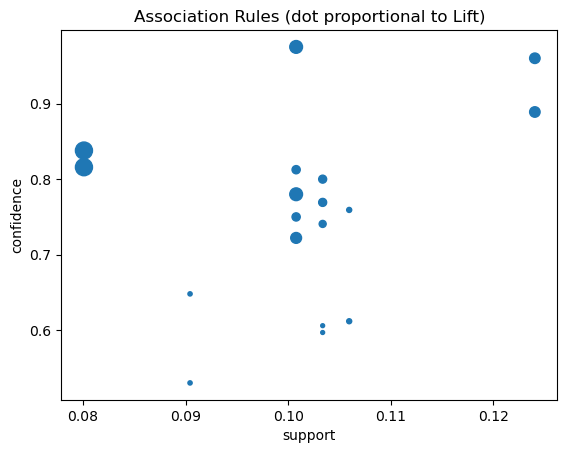

In [28]:
s = [1.8**n for n in rules['lift']]
rules.plot.scatter(x='support' 
                  ,y='confidence'
                  ,s=s
                  ,title='Association Rules (dot proportional to Lift)', 
                );

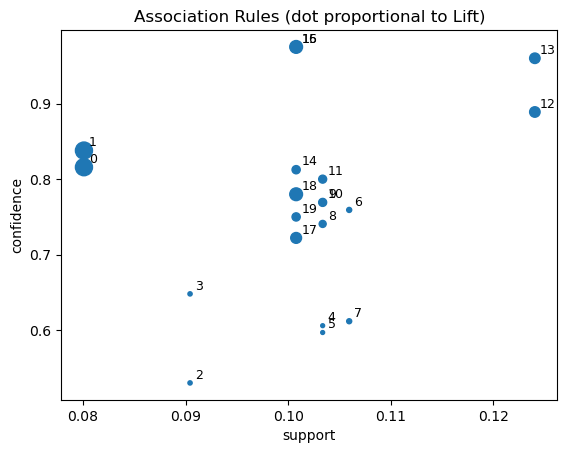

In [29]:
import matplotlib.pyplot as plt

s = [1.8**n for n in rules['lift']]
labels = rules.index

ax = rules.plot.scatter(
    x='support', 
    y='confidence', 
    s=s, 
    title='Association Rules (dot proportional to Lift)'
)

# Offset values for label placement
x_offset = 0.0005  # Adjust as needed
y_offset = 0.002  # Adjust as needed

# Add labels slightly away from the dots
for i, label in enumerate(labels):
    plt.text(
        rules['support'][i] + x_offset, 
        rules['confidence'][i] + y_offset, 
        str(label), 
        fontsize=9, 
        ha='left', 
        va='bottom'
    )

plt.show()
